### Deep Reinforcement Learning-based Image Captioning with Embedding Reward
Pranshu Gupta, Deep Learning @ Georgia Institute of Technology

In [19]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

from utils.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from utils.image_utils import image_from_url

from torchsummary import summary

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working on: ", device)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

max_seq_len = 17

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working on:  cuda:0


### Load MS-COCO data
We will use the Microsoft COCO dataset for captioning.

In [20]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

data["train_captions_lens"] = np.zeros(data["train_captions"].shape[0])
data["val_captions_lens"] = np.zeros(data["val_captions"].shape[0])
for i in range(data["train_captions"].shape[0]):
    data["train_captions_lens"][i] = np.nonzero(data["train_captions"][i] == 2)[0][0] + 1
for i in range(data["val_captions"].shape[0]):
    data["val_captions_lens"][i] = np.nonzero(data["val_captions"][i] == 2)[0][0] + 1


# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_captions_lens <class 'numpy.ndarray'> (400135,) float64
val_captions_lens <class 'numpy.ndarray'> (195954,) float64


In [21]:
small_data = load_coco_data(max_train=50000)

### Caption Evaluation

In [22]:
def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

### Policy Network

In [23]:
class PolicyNetwork(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(PolicyNetwork, self).__init__()
        
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        
        vocab_size = len(word_to_idx)
        
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        
        self.cnn2linear = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim, batch_first=True)
        self.linear2vocab = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, features, captions):
        input_captions = self.caption_embedding(captions)
        hidden_init = self.cnn2linear(features)
        cell_init = torch.zeros_like(hidden_init)
        output, _ = self.lstm(input_captions, (hidden_init, cell_init))
        output = self.linear2vocab(output)
        return output

### Training the Policy Network

In [44]:
policyNetwork = PolicyNetwork(data["word_to_idx"]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(policyNetwork.parameters(), lr=0.0001)

In [42]:
batch_size = 50
bestLoss = 10000 
#0.006700546946376562

for epoch in range(50000):
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    captions_in = torch.tensor(captions[:, :-1], device=device).long()
    captions_ou = torch.tensor(captions[:, 1:], device=device).long()
    output = policyNetwork(features, captions_in)
    
    loss = 0
    for i in range(batch_size):
        caplen = np.nonzero(captions[i] == 2)[0][0] + 1
        loss += (caplen/batch_size)*criterion(output[i][:caplen], captions_ou[i][:caplen])
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(policyNetwork.state_dict(), "policyNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 0 loss: -0.7622961401939392
epoch: 2 loss: -0.7967267632484436
epoch: 3 loss: -0.8298563361167908
epoch: 4 loss: -0.8488402962684631
epoch: 7 loss: -0.8808352947235107
epoch: 9 loss: -0.9272071123123169
epoch: 10 loss: -0.9303421974182129
epoch: 11 loss: -0.9743098020553589
epoch: 12 loss: -0.9925467371940613
epoch: 13 loss: -0.9987075924873352
epoch: 14 loss: -1.038584589958191
epoch: 15 loss: -1.0717610120773315
epoch: 16 loss: -1.1022742986679077
epoch: 17 loss: -1.1580274105072021
epoch: 18 loss: -1.1924822330474854
epoch: 19 loss: -1.2219786643981934
epoch: 20 loss: -1.288925290107727
epoch: 22 loss: -1.3553766012191772
epoch: 23 loss: -1.3997516632080078
epoch: 24 loss: -1.4628175497055054
epoch: 25 loss: -1.4969642162322998
epoch: 26 loss: -1.5474493503570557
epoch: 27 loss: -1.5780303478240967
epoch: 28 loss: -1.637071967124939
epoch: 29 loss: -1.7035317420959473
epoch: 30 loss: -1.7599382400512695
epoch: 31 loss: -1.7624255418777466
epoch: 32 loss: -1.79536771774292
epo

KeyboardInterrupt: 

### Testing the Policy Network

In [110]:
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('models/policyNetwork.pt'))
policyNet.train(mode=False)

def GenerateCaptions(features, captions, model):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    for t in range(max_seq_len-1):
        output = model(features, gen_caps)
        gen_caps = torch.cat((gen_caps, output[:, -1:, :].argmax(axis=2)), axis=1)
    return gen_caps, None

def GenerateCaptionsWithBeamSearch(features, captions, model, beamSize=5):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    candidates = [(gen_caps, 0)]
    for t in range(max_seq_len):
        next_candidates = []
        for c in range(len(candidates)):
            output = model(features, candidates[c][0])
            probs, words = torch.topk(output[:, -1:, :], beamSize)
            for i in range(beamSize):
                cap = torch.cat((candidates[c][0], words[:, :, i]), axis=1)
                score = candidates[c][1] - torch.log(probs[0, 0, i]).item()
                next_candidates.append((cap, score))
        ordered_candidates = sorted(next_candidates, key=lambda tup:tup[1])
        candidates = ordered_candidates[:beamSize]
    return candidates      

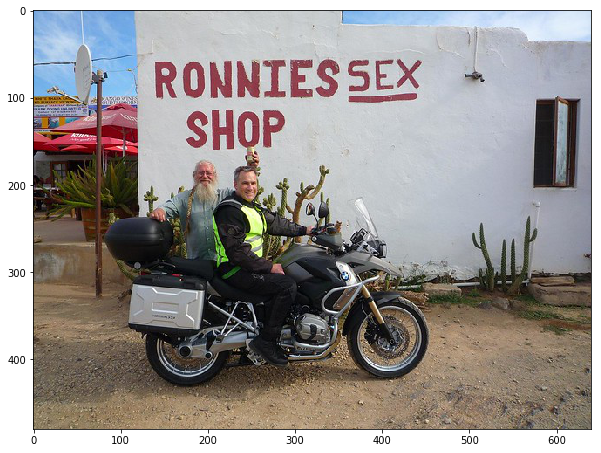

TRU: <START> a man wearing black and yellow and a man with a <UNK> <END>
GEN: <START> a man sitting on top of a red motorcycle <END>


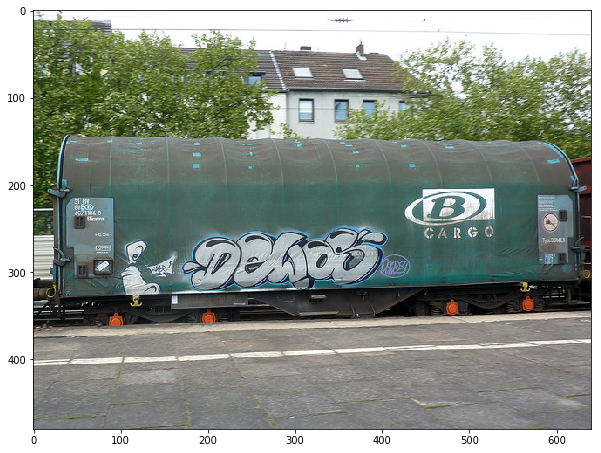

TRU: <START> a railroad car with graffiti <UNK> on the side parked on tracks <END>
GEN: <START> a black and white image of a street signs <END>


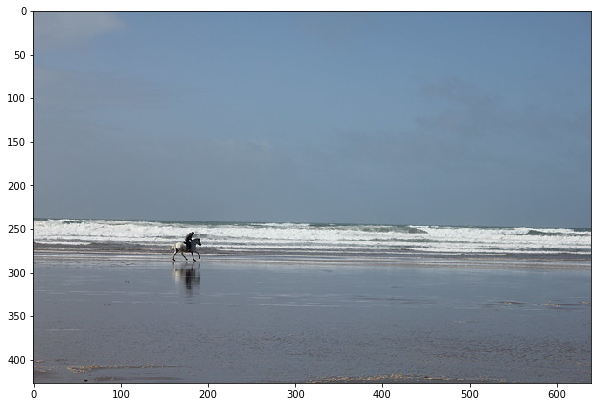

TRU: <START> a bird standing on to of a beach next to the ocean <END>
GEN: <START> a plane is <UNK> on the runway in the ocean <END>


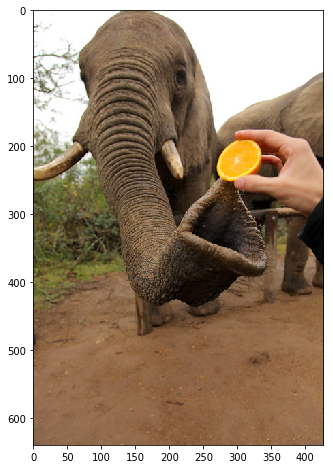

TRU: <START> a large elephant eating an orange <UNK> with its trunk <END>
GEN: <START> an elephant laying next to each other on the beach <END>


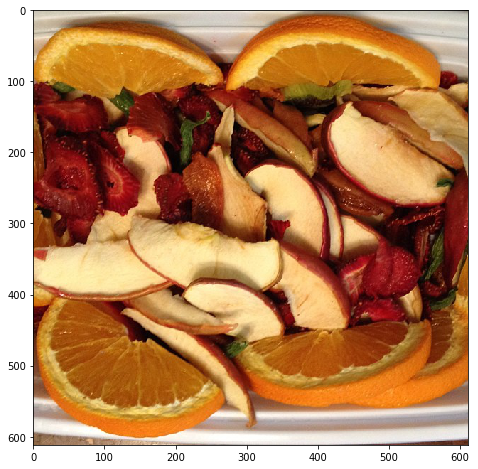

TRU: <START> as assortment of oranges and <UNK> and apples <END>
GEN: <START> a plate of food that are sitting on a table <END>


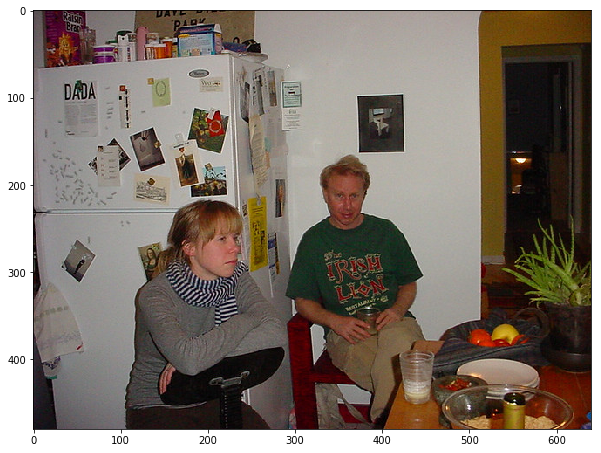

TRU: <START> two people sit in front of a refrigerator at a kitchen table <END>
GEN: <START> there is a man and woman <UNK> at a laptop table <END>


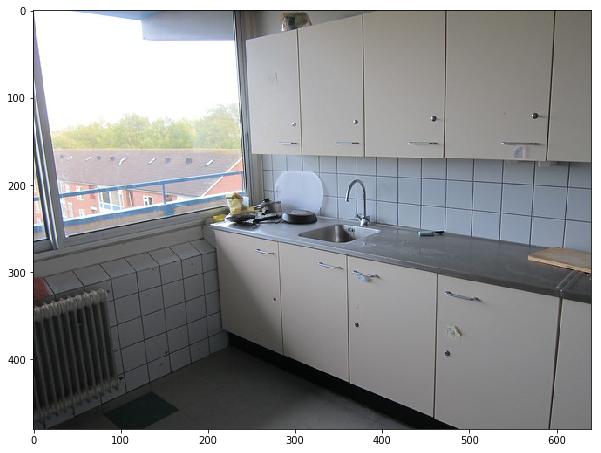

TRU: <START> a kitchen with tiled walls and a large window <END>
GEN: <START> a close up of a <UNK> view of a video game <END>


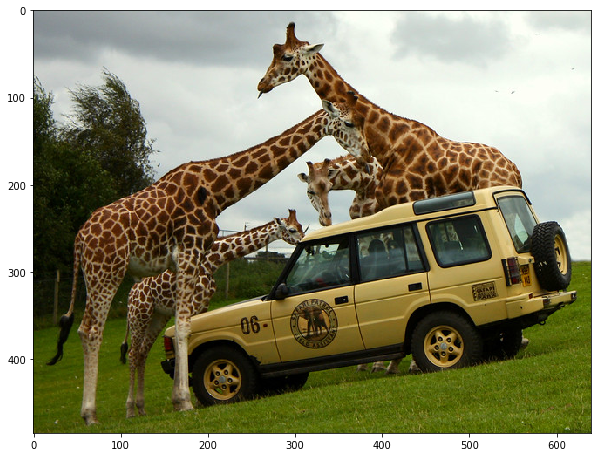

TRU: <START> a group of giraffe <UNK> around a park vehicle <END>
GEN: <START> a large clock tower <UNK> in the middle <END>


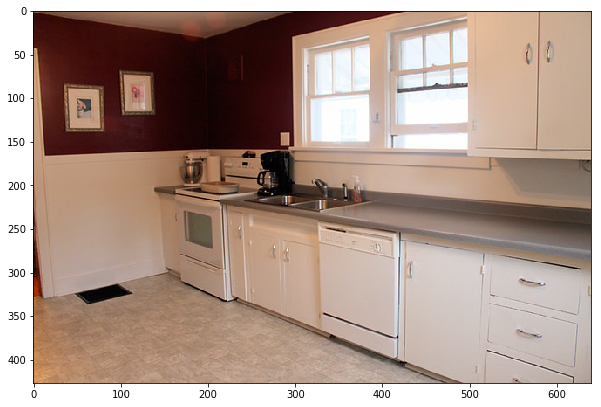

TRU: <START> a kitchen counter <UNK> and appliances all in white <END>
GEN: <START> a kitchen <UNK> with a stove and chair <END>


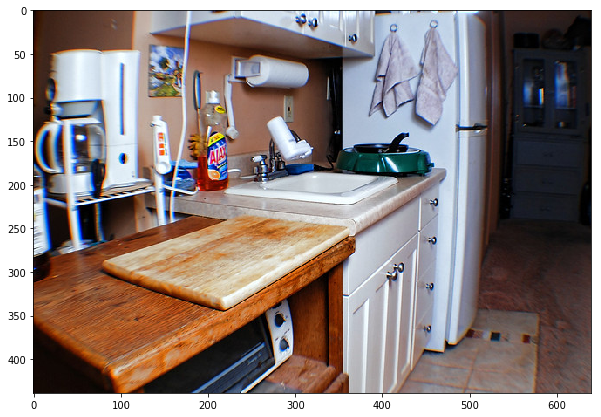

TRU: <START> a kitchen with a white fridge and sink <END>
GEN: <START> an image of a laptop computer setting on a wooden desk <END>


In [113]:
max_seq_len = 17
captions, features, urls = sample_coco_minibatch(small_data, batch_size=10, split='train')
for i in range(10):
    gen_caps = GenerateCaptionsWithBeamSearch(features[i:i+1], captions[i:i+1], policyNet)
    decoded_tru_caps = decode_captions(captions[i], data["idx_to_word"])
    try:
        plt.imshow(image_from_url(urls[i]))
        plt.show()
    except:
        continue
    print("TRU:", decoded_tru_caps)
    for cap in gen_caps[0:1]:
        decoded_gen_caps = decode_captions(cap[0], data["idx_to_word"])[0]
        print("GEN:", decoded_gen_caps)
#     print(BLEU_score(decoded_tru_caps, decoded_gen_caps))

### Reward Network

In [7]:
class RewardNetworkRNN(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(RewardNetworkRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)
        
        self.hidden_cell = torch.zeros(1, 1, self.hidden_dim).to(device)
        
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        self.gru = nn.GRU(wordvec_dim, hidden_dim)
    
    def forward(self, captions):
        input_captions = self.caption_embedding(captions)
        output, self.hidden_cell = self.gru(input_captions.view(len(input_captions) ,1, -1), self.hidden_cell)
        return output
    
class RewardNetwork(nn.Module):
    def __init__(self, word_to_idx):
        super(RewardNetwork, self).__init__()
        self.rewrnn = RewardNetworkRNN(word_to_idx)
        self.visual_embed = nn.Linear(512, 512)
        self.semantic_embed = nn.Linear(512, 512)
        
    def forward(self, features, captions):
        for t in range(captions.shape[1]):
            rrnn = self.rewrnn(captions[:, t])
        rrnn = rrnn.squeeze(0).squeeze(1)
        se = self.semantic_embed(rrnn)
        ve = self.visual_embed(features)
        return ve, se

In [66]:
rewardNetwork = RewardNetwork(data["word_to_idx"]).to(device)
optimizer = optim.Adam(rewardNetwork.parameters(), lr=0.001)

# https://cs230-stanford.github.io/pytorch-nlp.html#writing-a-custom-loss-function
def VisualSemanticEmbeddingLoss(visuals, semantics):
    beta = 0.002
    N, D = visuals.shape
    
    visloss = torch.mm(visuals, semantics.t())
    visloss = visloss - torch.diag(visloss).unsqueeze(1)
    visloss = visloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    visloss = F.relu(visloss)
    visloss = torch.sum(visloss)/N
    
    semloss = torch.mm(semantics, visuals.t())
    semloss = semloss - torch.diag(semloss).unsqueeze(1)
    semloss = semloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    semloss = F.relu(semloss)
    semloss = torch.sum(semloss)/N
    
    return visloss + semloss        

In [69]:
batch_size = 50
bestLoss = 10000

for epoch in range(50000):
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    captions = torch.tensor(captions, device=device).long()
    ve, se = rewardNetwork(features, captions)
    loss = VisualSemanticEmbeddingLoss(ve, se)
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(rewardNetwork.state_dict(), "rewardNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rewardNetwork.rewrnn.hidden_cell.detach_()

epoch: 0 loss: 153.8406219482422
epoch: 1 loss: 145.78004455566406
epoch: 2 loss: 144.26637268066406
epoch: 5 loss: 127.2883529663086
epoch: 17 loss: 126.70248413085938
epoch: 21 loss: 122.92036437988281
epoch: 45 loss: 117.26567077636719
epoch: 48 loss: 109.99120330810547
epoch: 56 loss: 105.07620239257812
epoch: 183 loss: 104.64308166503906
epoch: 198 loss: 96.82013702392578
epoch: 209 loss: 94.6942138671875
epoch: 275 loss: 93.03327178955078
epoch: 286 loss: 86.01957702636719
epoch: 345 loss: 83.19971466064453
epoch: 402 loss: 82.8239974975586
epoch: 447 loss: 80.05474853515625
epoch: 450 loss: 66.36756134033203
epoch: 589 loss: 53.008888244628906
epoch: 825 loss: 52.94926452636719
epoch: 964 loss: 52.840293884277344
epoch: 965 loss: 52.49498748779297
epoch: 974 loss: 51.35733413696289
epoch: 983 loss: 49.916099548339844
epoch: 984 loss: 48.341064453125
epoch: 1031 loss: 46.65217590332031
epoch: 1099 loss: 44.16111373901367
epoch: 1141 loss: 41.64582061767578
epoch: 1358 loss: 39.97

In [12]:
def GetRewards(features, captions, model):
    visEmbeds, semEmbeds = model(features, captions)
    visEmbeds = F.normalize(visEmbeds, p=2, dim=1) 
    semEmbeds = F.normalize(semEmbeds, p=2, dim=1) 
    rewards = torch.sum(visEmbeds*semEmbeds, axis=1).unsqueeze(1)
    return rewards

### Value Network

In [8]:
class ValueNetworkRNN(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(ValueNetworkRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)
        
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_dim).to(device), torch.zeros(1, 1, self.hidden_dim).to(device))
        
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim)
        
    def forward(self, captions):
        input_captions = self.caption_embedding(captions)
        output, self.hidden_cell = self.lstm(input_captions.view(len(input_captions) ,1, -1), self.hidden_cell)
        return output
    
class ValueNetwork(nn.Module):
    def __init__(self, word_to_idx):
        super(ValueNetwork, self).__init__()
        self.valrnn = ValueNetworkRNN(word_to_idx)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 1)
    
    def forward(self, features, captions):
        for t in range(captions.shape[1]):
            vrnn = self.valrnn(captions[:, t])
        vrnn = vrnn.squeeze(0).squeeze(1)
        state = torch.cat((features, vrnn), dim=1)
        output = self.linear1(state)
        output = self.linear2(output)
        return output

In [111]:
rewardNet = RewardNetwork(data["word_to_idx"]).to(device)
rewardNet.load_state_dict(torch.load('models/rewardNetwork.pt'))
for param in rewardNet.parameters():
    param.require_grad = False
print(rewardNet)

policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('models/policyNetwork.pt'))
for param in policyNet.parameters():
    param.require_grad = False
print(policyNet)

valueNetwork = ValueNetwork(data["word_to_idx"]).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(valueNetwork.parameters(), lr=0.0001)
valueNetwork.train(mode=True)

RewardNetwork(
  (rewrnn): RewardNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (gru): GRU(512, 512)
  )
  (visual_embed): Linear(in_features=512, out_features=512, bias=True)
  (semantic_embed): Linear(in_features=512, out_features=512, bias=True)
)
PolicyNetwork(
  (caption_embedding): Embedding(1004, 512)
  (cnn2linear): Linear(in_features=512, out_features=512, bias=True)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear2vocab): Linear(in_features=512, out_features=1004, bias=True)
  (probs): Softmax(dim=1)
)


ValueNetwork(
  (valrnn): ValueNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (lstm): LSTM(512, 512)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
batch_size = 50
bestLoss = 10000
max_seq_len = 17

for epoch in range(50000):
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    
    # Generate captions using the policy network
    captions = GenerateCaptions(features, captions, policyNet)
    
    # Compute the reward of the generated caption using reward network
    rewards = GetRewards(features, captions, rewardNet)
    
    # Compute the value of a random state in the generation process
    values = valueNetwork(features, captions[:, :random.randint(1, 17)])
    
    # Compute the loss for the value and the reward
    loss = criterion(values, rewards)
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(valueNetwork.state_dict(), "valueNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valueNetwork.valrnn.hidden_cell[0].detach_()
    valueNetwork.valrnn.hidden_cell[1].detach_()
    rewardNet.rewrnn.hidden_cell.detach_()

/home/patcha/anaconda3/envs/pranshu/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch: 0 loss: 0.3092360496520996
epoch: 4 loss: 0.27171164751052856
epoch: 6 loss: 0.24631603062152863
epoch: 7 loss: 0.23289050161838531
epoch: 8 loss: 0.14369864761829376
epoch: 10 loss: 0.135650172829628
epoch: 12 loss: 0.12473323196172714
epoch: 14 loss: 0.08560443669557571
epoch: 17 loss: 0.0806381031870842
epoch: 21 loss: 0.07396671921014786
epoch: 23 loss: 0.07384121417999268
epoch: 29 loss: 0.06516725569963455
epoch: 30 loss: 0.033539995551109314
epoch: 40 loss: 0.01902606524527073
epoch: 59 loss: 0.014212993904948235
epoch: 62 loss: 0.014187989756464958
epoch: 63 loss: 0.009411291219294071
epoch: 74 loss: 0.007882441394031048
epoch: 77 loss: 0.0074298023246228695
epoch: 78 loss: 0.007236851379275322
epoch: 80 loss: 0.005417762324213982
epoch: 88 loss: 0.004258515313267708
epoch: 91 loss: 0.004118920303881168
epoch: 95 loss: 0.0034138027112931013
epoch: 101 loss: 0.003200941951945424
epoch: 103 loss: 0.0027566079515963793
epoch: 109 loss: 0.00170118547976017
epoch: 119 loss: 0

## Reinforcement Learning
Advantage Actor Critic Model for Reinforcement Learning

In [9]:
class AdvantageActorCriticNetwork(nn.Module):
    def __init__(self, valueNet, policyNet):
        super(AdvantageActorCriticNetwork, self).__init__()

        self.valueNet = valueNet #RewardNetwork(data["word_to_idx"]).to(device)
        self.policyNet = policyNet #PolicyNetwork(data["word_to_idx"]).to(device)

    def forward(self, features, captions):
        # Get value from value network
        values = self.valueNet(features, captions)
        # Get action probabilities from policy network
        probs = self.policyNet(features.unsqueeze(0), captions)[:, -1:, :]        
        return values, probs 

In [14]:
rewardNet = RewardNetwork(data["word_to_idx"]).to(device)
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
valueNet = ValueNetwork(data["word_to_idx"]).to(device)

rewardNet.load_state_dict(torch.load('models/rewardNetwork.pt'))
policyNet.load_state_dict(torch.load('models/policyNetwork.pt'))
valueNet.load_state_dict(torch.load('models/valueNetwork.pt'))

a2cNetwork = AdvantageActorCriticNetwork(valueNet, policyNet)
optimizer = optim.Adam(a2cNetwork.parameters(), lr=0.0001)

### Curriculum Learning

In [17]:
curriculum = [2, 4, 6, 8, 10, 12, 14, 16]
episodes = 50

small_data = load_coco_data(max_train=50000)

for level in curriculum:
    
    for epoch in range(1000):        
        episodicAvgLoss = 0
        
        captions, features, _ = sample_coco_minibatch(small_data, batch_size=episodes, split='train')
        features = torch.tensor(features, device=device).float()
        captions = torch.tensor(captions, device=device).long()
        
        for episode in range(episodes):
            log_probs = []
            values = []
            rewards = []
            caplen = np.nonzero(captions[episode] == 2)[0][0] + 1
            
            if (caplen - level > 1):
                captions_in = captions[episode:episode+1, :caplen-level]
                features_in = features[episode:episode+1]

                for step in range(level):
                    value, probs = a2cNetwork(features_in, captions_in)
                    probs = F.softmax(probs, dim=2)
                    
                    dist = probs.cpu().detach().numpy()[0,0]
                    action = np.random.choice(probs.shape[-1], p=dist)
                    
                    gen_cap = torch.from_numpy(np.array([action])).unsqueeze(0).to(device)
                    captions_in = torch.cat((captions_in, gen_cap), axis=1)
                    
                    log_prob = torch.log(probs[0, 0, action])
                    
                    reward = GetRewards(features_in, captions_in, rewardNet)
                    reward = reward.cpu().detach().numpy()[0, 0]
                    
                    rewards.append(reward)
                    values.append(value)
                    log_probs.append(log_prob)
                    
            values = torch.FloatTensor(values).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            log_probs = torch.stack(log_probs).to(device)
            
            advantage = values - rewards 
            actorLoss = (-log_probs * advantage).mean()
            criticLoss = 0.5 * advantage.pow(2).mean()
            
            loss = actorLoss + criticLoss
            episodicAvgLoss += loss.item()/episodes
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(epoch, ":", episodicAvgLoss)

0 : 0.02320903023704886
1 : 0.01312393933010753
2 : 0.00771524380070332
3 : -0.007593203229771461
4 : -0.001424596389406362
5 : 0.00989914114077692
6 : 0.005231798512540989
7 : 0.006629595400008839
8 : 0.012109559222590178
9 : -0.0006239669210481226
10 : 0.009723953194916247
11 : 0.0044474254810484126
12 : 0.008023221267485496
13 : 0.0056188294969615514
14 : 0.003599554880929643
15 : 0.005732270738044463
16 : 0.0060812147264368835
17 : 0.004769039509592402
18 : 0.005961071758065374
19 : 0.004842769111783126
20 : 0.004504630964001989
21 : 0.005190590277634326
22 : 0.005683154103317063
23 : 0.0034073841822100793
24 : 0.008774827713496051
25 : 0.00917623785826436
26 : 0.004189597215736285
27 : -0.0027697008736140573
28 : 0.005185449457094364
29 : 0.0045179704393376605
30 : 0.0042511611874215295
31 : -0.0078844551929069
32 : 0.007009633950765419
33 : 0.010297190369747113
34 : 0.004855246039951453
35 : 0.004842445416725242
36 : 0.0050522680560970935
37 : 0.005479029436974087
38 : 0.00791874

KeyboardInterrupt: 

### Beam Search on Policy Network